# Práctica 2: Calibración del Túnel de Viento con datos LDA

Este cuaderno procesa automáticamente los archivos de `files/p2`, calcula la tabla de calibración (Velocidad media vs Frecuencia), ajusta el modelo lineal (y opcionalmente polinomial), genera y guarda todas las figuras en `Practicas/P02_Calibracion_Tunel/data/images` en formatos PNG y SVG, e incluye controles interactivos para explorar variantes.

Contenido breve:
- Descubrimiento y limpieza de datos LDA.
- Estadísticos por archivo y por frecuencia.
- Tabla de calibración y exportación (CSV/Parquet/JSON).
- Gráficas con barras de error, línea ajustada y residuales.
- Widgets para filtrar frecuencias, elegir método de agregación y modelo (lineal/grado 2), fijar b=0.
- Caso de estudio: cálculo de f desde V y V desde f, Reynolds (Re).
- Opción de actualizar `p2.md` con resultados.

Requisitos: numpy, pandas, matplotlib, seaborn, scipy (opcional), ipywidgets, tqdm. Si falta alguna dependencia, ejecuta la celda de instalación.


In [1]:
# 1) Configuración del entorno y dependencias
import sys, os, json, math, logging, datetime as dt
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import ipywidgets as widgets
except Exception as e:
    print("ipywidgets no disponible. Puedes instalarlo y recargar el cuaderno.")
    widgets = None
from importlib import reload
src_path = Path('../src').resolve()
if str(src_path) not in sys.path: # Evita añadir la ruta múltiples veces
    sys.path.append(str(src_path))
    print(f"Añadido a sys.path: {src_path}")
else:
    print(f"Ruta ya en sys.path: {src_path}")
import calib_utils as cu
reload(cu)
# Configuración global de gráficos y logging
sns.set(context='notebook', style='whitegrid', palette='deep')
plt.rcParams['figure.dpi'] = 110
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
logger = logging.getLogger("P02")
project_root = Path.cwd().parent # Esto ahora es .../P02_Calibracion_Tunel/
# Directorios base
images_dir = project_root / 'data' / 'images'
data_dir = project_root / 'data'
cu.ensure_dir(images_dir)
cu.ensure_dir(data_dir)
REQS = ['numpy','pandas','matplotlib','seaborn','ipywidgets','scipy','tqdm']
print('Si falta alguna dependencia, ejecuta:')
print('%pip install -r requirements.txt  # en una celda mágico de Jupyter')

Añadido a sys.path: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\src
Si falta alguna dependencia, ejecuta:
%pip install -r requirements.txt  # en una celda mágico de Jupyter


In [2]:
# 2) Descubrimiento de datos en files/p2 y extracción de frecuencias
try:
    p2_root = cu.find_p2_data_root()
except FileNotFoundError as e:
    logger.error(str(e))
    raise

discovered = []
for freq, fpath in cu.iter_lda_files(p2_root):
    discovered.append({'file': str(fpath), 'frequency_hz': int(freq)})
df_files = pd.DataFrame(discovered).sort_values(['frequency_hz','file']).reset_index(drop=True)
display(df_files.head())

expected_freqs = list(range(5, 60, 5))  # 5,10,...,55
present = sorted(df_files['frequency_hz'].unique().tolist())
missing = sorted(set(expected_freqs) - set(present))
logger.info(f"Frecuencias detectadas: {present}")
if missing:
    logger.warning(f"Frecuencias esperadas no encontradas: {missing}")

,file,frequency_hz
0,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,5
1,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,10
2,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15
3,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,20
4,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,25


[INFO] Frecuencias detectadas: [5, 10, 15, 20, 25, 35, 40, 45, 50, 55]
[WARNING] Frecuencias esperadas no encontradas: [30]


In [3]:
# 3) Utilidades de carga y limpieza + 4) Estadísticos por archivo
def load_and_stats_per_file(df_files: pd.DataFrame, abs_values: bool = True) -> pd.DataFrame:
    rows = []
    for _, r in df_files.iterrows():
        f = Path(r['file'])
        try:
            s = cu.read_lda_speeds(f, abs_values=abs_values)
            rows.append({
                'file': str(f),
                'frequency_hz': int(r['frequency_hz']),
                'mean_ms': float(s.mean()),
                'std_ms': float(s.std(ddof=1)),
                'n_samples': int(s.shape[0]),
            })
        except Exception as ex:
            logger.warning(f"No se pudo leer {f}: {ex}")
            continue
    return pd.DataFrame(rows).sort_values(['frequency_hz','file']).reset_index(drop=True)

per_file_stats = load_and_stats_per_file(df_files)
display(per_file_stats.head())
logger.info(f"Archivos válidos: {len(per_file_stats)}")

,file,frequency_hz,mean_ms,std_ms,n_samples
0,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,5,5.198702,0.043634,2000
1,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,10,10.987320,0.296362,2000
2,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15,16.785100,1.709956,2000
3,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,20,23.172521,0.793461,2000
4,C:\Users\edgar\Documents\GitHub\Aero-Messure\f...,25,28.913653,4.214683,2000


[INFO] Archivos válidos: 29


In [4]:
# 5) Agregación por frecuencia (promedio ponderado por N)
def aggregate_by_frequency(per_file: pd.DataFrame, method: str = 'weighted') -> pd.DataFrame:
    # method: 'simple' o 'weighted'
    rows = []
    for freq, grp in per_file.groupby('frequency_hz'):
        means = grp['mean_ms'].to_numpy()
        ns = grp['n_samples'].to_numpy()
        if method == 'weighted' and ns.sum() > 0:
            mean_avg = float(np.average(means, weights=ns))
        else:
            mean_avg = float(np.mean(means))
        # Pooled std
        stds = grp['std_ms'].to_numpy()
        denom = np.sum(np.maximum(ns - 1, 1))
        if denom > 0:
            pooled_var = float(np.sum((np.maximum(ns - 1, 1)) * (stds ** 2)) / denom)
            pooled_std = float(np.sqrt(pooled_var))
        else:
            pooled_std = float(np.std(means, ddof=1)) if len(means) > 1 else 0.0
        rows.append({
            'frequency_hz': int(freq),
            'U_mean_ms': mean_avg,
            'U_std_ms': pooled_std,
            'n_total': int(ns.sum()),
            'n_files': int(len(grp)),
            'aggregation': method,
        })
    return pd.DataFrame(rows).sort_values('frequency_hz').reset_index(drop=True)

per_freq_weighted = aggregate_by_frequency(per_file_stats, method='weighted')
per_freq_simple = aggregate_by_frequency(per_file_stats, method='simple')
display(per_freq_weighted)

,frequency_hz,U_mean_ms,U_std_ms,n_total,n_files,aggregation
0,5,5.198702,0.043634,2000,1,weighted
1,10,10.987320,0.296362,2000,1,weighted
2,15,16.785100,1.709956,2000,1,weighted
3,20,23.172521,0.793461,2000,1,weighted
4,25,28.913653,4.214683,2000,1,weighted
5,35,41.504591,3.909275,10000,5,weighted
6,40,47.386152,4.869168,10000,5,weighted
7,45,54.880136,6.291958,10000,5,weighted
8,50,60.781742,6.224235,10000,5,weighted
9,55,66.690161,5.251492,8000,4,weighted


In [5]:
# 6) Guardado de la tabla de calibración a CSV/Parquet
calib_csv = data_dir / 'calibracion.csv'
calib_parquet = data_dir / 'calibracion.parquet'
per_freq_weighted.to_csv(calib_csv, index=False)
try:
    per_freq_weighted.to_parquet(calib_parquet, index=False)
except Exception as ex:
    logger.info(f"No se guardó Parquet (opcional): {ex}")
print('Tablas guardadas en:')
print(calib_csv)
print(calib_parquet) if calib_parquet.exists() else None

Tablas guardadas en:
c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\calibracion.csv
c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\calibracion.parquet


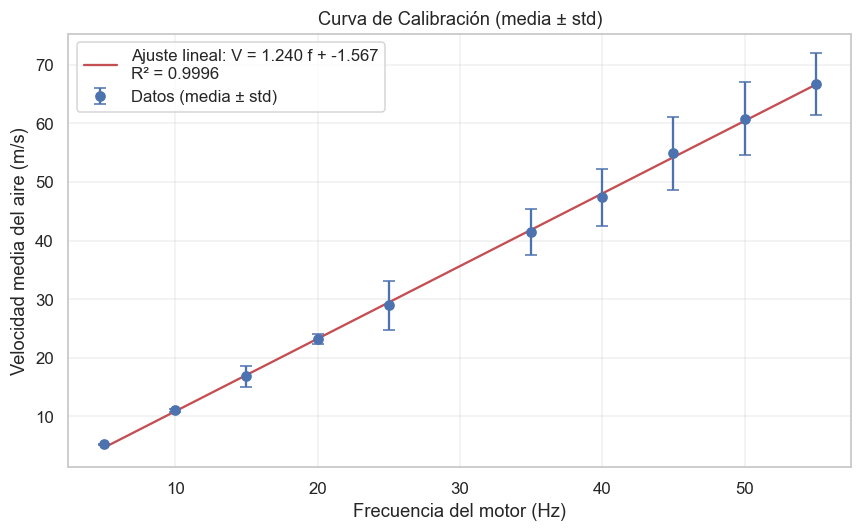

Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\images\calibracion_scatter.png
Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\images\calibracion_scatter.svg


In [6]:
# 7) Gráficas de calibración (scatter + barras de error) y guardado PNG/SVG
fig, ax = cu.plot_calibration(per_freq_weighted.rename(columns={'U_mean_ms':'mean_speed_ms','U_std_ms':'std_speed_ms'}), include_errorbars=True, title='Curva de Calibración (media ± std)')
png_path, svg_path = cu.save_figure(fig, images_dir, 'calibracion_scatter')
plt.show()
print('Guardado:', png_path)
print('Guardado:', svg_path)

Ecuación (lineal): V = 1.239888 f + -1.566626  |  R^2 = 0.999587


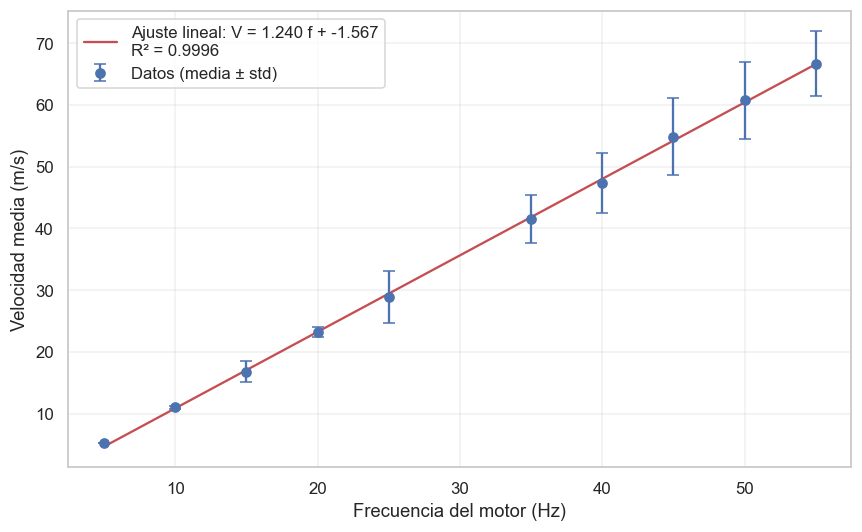

Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\images\calibracion_ajuste_lineal.png
Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\images\calibracion_ajuste_lineal.svg


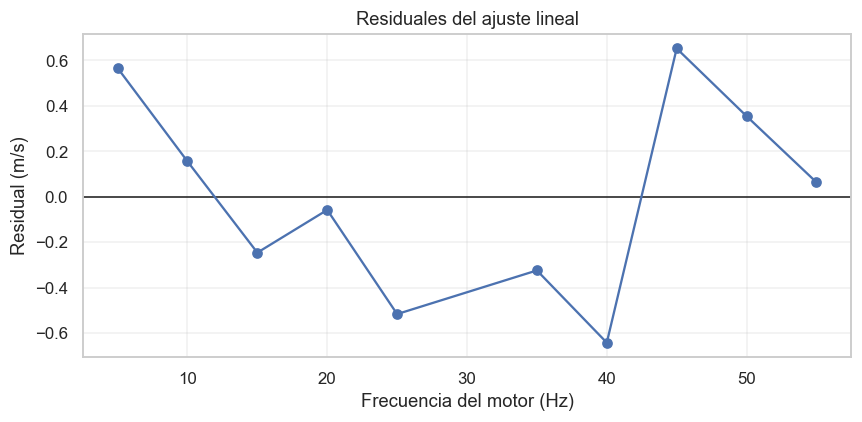

Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\images\calibracion_residuales.png
Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\images\calibracion_residuales.svg


In [7]:
# 8) Regresión lineal: m, b, R^2; residuales y guardado
x = per_freq_weighted['frequency_hz'].to_numpy()
y = per_freq_weighted['U_mean_ms'].to_numpy()
m, b, r2 = cu.fit_linear(x, y)
print(f"Ecuación (lineal): V = {m:.6f} f + {b:.6f}  |  R^2 = {r2:.6f}")

# Línea ajustada sobre el scatter
fig2, ax2 = plt.subplots(figsize=(8,5))
ax2.errorbar(x, y, yerr=per_freq_weighted['U_std_ms'].to_numpy(), fmt='o', capsize=4, label='Datos (media ± std)')
xf = np.linspace(x.min(), x.max(), 200)
ax2.plot(xf, m*xf + b, 'r-', label=f'Ajuste lineal: V = {m:.3f} f + {b:.3f}\nR² = {r2:.4f}')
ax2.set_xlabel('Frecuencia del motor (Hz)')
ax2.set_ylabel('Velocidad media (m/s)')
ax2.grid(True, alpha=0.3)
ax2.legend()
fig2.tight_layout()
png2, svg2 = cu.save_figure(fig2, images_dir, 'calibracion_ajuste_lineal')
plt.show()
print('Guardado:', png2)
print('Guardado:', svg2)

# Residuales
resid = y - (m*x + b)
fig3, ax3 = plt.subplots(figsize=(8,4))
ax3.axhline(0, color='k', lw=1)
ax3.plot(x, resid, 'o-')
ax3.set_xlabel('Frecuencia del motor (Hz)')
ax3.set_ylabel('Residual (m/s)')
ax3.set_title('Residuales del ajuste lineal')
ax3.grid(True, alpha=0.3)
fig3.tight_layout()
png3, svg3 = cu.save_figure(fig3, images_dir, 'calibracion_residuales')
plt.show()
print('Guardado:', png3)
print('Guardado:', svg3)

Polinomial grado 2: V = 1.276244e-03 f^2 + 1.163313 f + -0.768974  |  R^2 = 0.999767


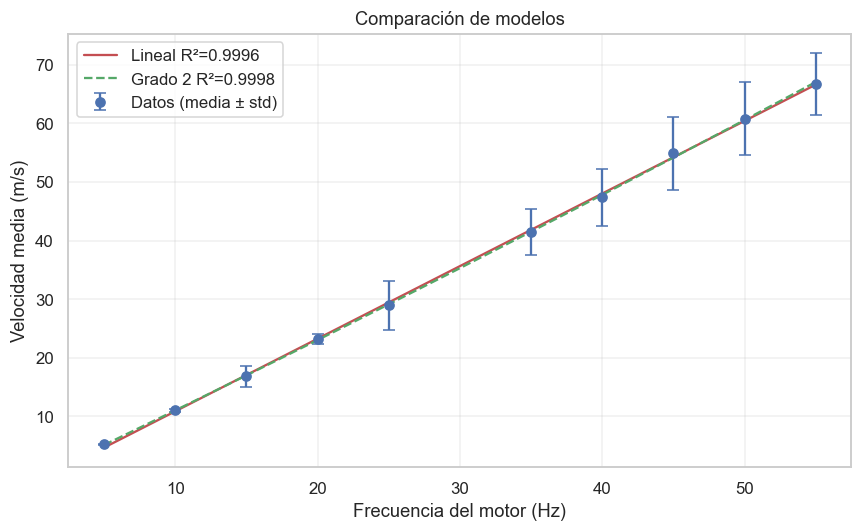

Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\images\calibracion_modelos_comparacion.png
Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\images\calibracion_modelos_comparacion.svg


In [8]:
# 9) Alternativa polinomial grado 2 y comparación de R^2
def fit_poly2(x, y):
    coeffs = np.polyfit(x, y, deg=2)  # a, b, c
    a, b2, c = coeffs
    yhat = a*x**2 + b2*x + c
    ss_res = float(np.sum((y - yhat)**2))
    ss_tot = float(np.sum((y - float(np.mean(y)))**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else 0.0
    return a, b2, c, r2

a2, b2, c2, r2q = fit_poly2(x, y)
print(f"Polinomial grado 2: V = {a2:.6e} f^2 + {b2:.6f} f + {c2:.6f}  |  R^2 = {r2q:.6f}")

# Graficar comparación
fig4, ax4 = plt.subplots(figsize=(8,5))
ax4.errorbar(x, y, yerr=per_freq_weighted['U_std_ms'].to_numpy(), fmt='o', capsize=4, label='Datos (media ± std)')
xf = np.linspace(x.min(), x.max(), 200)
ax4.plot(xf, m*xf + b, 'r-', label=f'Lineal R²={r2:.4f}')
ax4.plot(xf, a2*xf**2 + b2*xf + c2, 'g--', label=f'Grado 2 R²={r2q:.4f}')
ax4.set_xlabel('Frecuencia del motor (Hz)')
ax4.set_ylabel('Velocidad media (m/s)')
ax4.set_title('Comparación de modelos')
ax4.grid(True, alpha=0.3)
ax4.legend()
fig4.tight_layout()
png4, svg4 = cu.save_figure(fig4, images_dir, 'calibracion_modelos_comparacion')
plt.show()
print('Guardado:', png4)
print('Guardado:', svg4)

In [9]:
# 10) Widgets interactivos para filtrado y tipo de ajuste
if widgets is None:
    print('Widgets no disponibles. Instala ipywidgets y recarga el notebook.')
else:
    freq_options = sorted(per_freq_weighted['frequency_hz'].unique().tolist())
    sel_freqs = widgets.SelectMultiple(options=freq_options, value=tuple(freq_options), description='Frecuencias')
    agg_method = widgets.ToggleButtons(options=['weighted','simple'], value='weighted', description='Agregación')
    model_sel = widgets.ToggleButtons(options=['lineal','grado2'], value='lineal', description='Modelo')
    fix_b0 = widgets.Checkbox(value=False, description='Fijar b=0 (lineal)')
    out_text = widgets.Output()

    def recompute_and_plot(*args):
        with out_text:
            out_text.clear_output()
            # Reagregar según método
            per_freq = aggregate_by_frequency(per_file_stats[per_file_stats['frequency_hz'].isin(sel_freqs.value)], method=agg_method.value)
            display(per_freq)
            x = per_freq['frequency_hz'].to_numpy()
            y = per_freq['U_mean_ms'].to_numpy()
            if model_sel.value == 'lineal':
                if fix_b0.value:
                    # Ajuste lineal con b=0 -> m = (x^T y)/(x^T x)
                    m_fit = float((x@y)/(x@x)) if (x@x) != 0 else float('nan')
                    b_fit = 0.0
                    yhat = m_fit * x
                    ss_res = float(np.sum((y - yhat)**2))
                    ss_tot = float(np.sum((y - float(np.mean(y)))**2))
                    r2_fit = 1.0 - ss_res/ss_tot if ss_tot > 0 else 0.0
                else:
                    m_fit, b_fit, r2_fit = cu.fit_linear(x, y)
                print(f"(Interactivo) Lineal: V = {m_fit:.6f} f + {b_fit:.6f} | R^2 = {r2_fit:.6f}")
                figi, axi = plt.subplots(figsize=(8,5))
                axi.errorbar(x, y, yerr=per_freq['U_std_ms'].to_numpy(), fmt='o', capsize=4, label='Datos')
                xf = np.linspace(x.min(), x.max(), 200) if len(x)>1 else x
                axi.plot(xf, m_fit*xf + b_fit, 'r-', label='Ajuste lineal')
                axi.set_xlabel('Frecuencia (Hz)')
                axi.set_ylabel('Velocidad media (m/s)')
                axi.grid(True, alpha=0.3)
                axi.legend()
                figi.tight_layout()
                fname = f"calibracion_interactivo_{agg_method.value}_{model_sel.value}{'_b0' if fix_b0.value else ''}"
                cu.save_figure(figi, images_dir, fname)
                plt.show()
            else:
                # grado 2
                a_fit, b_fit, c_fit, r2_fit = fit_poly2(x, y)
                print(f"(Interactivo) Grado2: V = {a_fit:.6e} f^2 + {b_fit:.6f} f + {c_fit:.6f} | R^2 = {r2_fit:.6f}")
                figi, axi = plt.subplots(figsize=(8,5))
                axi.errorbar(x, y, yerr=per_freq['U_std_ms'].to_numpy(), fmt='o', capsize=4, label='Datos')
                xf = np.linspace(x.min(), x.max(), 200) if len(x)>1 else x
                axi.plot(xf, a_fit*xf**2 + b_fit*xf + c_fit, 'g--', label='Ajuste grado 2')
                axi.set_xlabel('Frecuencia (Hz)')
                axi.set_ylabel('Velocidad media (m/s)')
                axi.grid(True, alpha=0.3)
                axi.legend()
                figi.tight_layout()
                fname = f"calibracion_interactivo_{agg_method.value}_{model_sel.value}"
                cu.save_figure(figi, images_dir, fname)
                plt.show()

    ui = widgets.VBox([widgets.HBox([sel_freqs, widgets.VBox([agg_method, model_sel, fix_b0])]), out_text])
    for w in [sel_freqs, agg_method, model_sel, fix_b0]:
        w.observe(recompute_and_plot, names='value')
    display(ui)
    recompute_and_plot()

In [10]:
# 11) Caso de estudio: f desde V, V desde f; Reynolds
def v_from_f_lineal(f, m, b):
    return m*float(f) + b
def f_from_v_lineal(V, m, b):
    return cu.invert_calibration(V, m, b)
def v_from_f_poly2(f, a, b2, c):
    f = float(f)
    return a*f*f + b2*f + c

case_out = widgets.Output() if widgets else None
if widgets is None:
    # Muestra usando el ajuste lineal base (m,b)
    V_obj = 12.0
    f_req = f_from_v_lineal(V_obj, m, b)
    print(f"Para V={V_obj} m/s, frecuencia requerida ≈ {f_req:.2f} Hz (lineal)")
else:
    V_input = widgets.FloatText(value=12.0, description='V objetivo (m/s)')
    f_input = widgets.FloatText(value=28.0, description='f (Hz)')
    L_input = widgets.FloatText(value=0.1, description='L (m)')
    nu_input = widgets.FloatText(value=1.5e-5, description='nu (m^2/s)')
    model_cs = widgets.ToggleButtons(options=['lineal','grado2'], value='lineal', description='Modelo')
    run_btn = widgets.Button(description='Calcular', button_style='success')

    def on_calc(btn=None):
        with case_out:
            case_out.clear_output()
            f_val = float(f_input.value)
            V_obj = float(V_input.value)
            L = float(L_input.value)
            nu = float(nu_input.value)
            # Por defecto usamos per_freq_weighted para rango
            x_range = (per_freq_weighted['frequency_hz'].min(), per_freq_weighted['frequency_hz'].max())
            if model_cs.value == 'lineal':
                V_pred = v_from_f_lineal(f_val, m, b)
                f_req = f_from_v_lineal(V_obj, m, b)
                print(f"[Lineal] Para f={f_val:.2f} Hz, V≈{V_pred:.3f} m/s | Para V={V_obj:.3f} m/s -> f≈{f_req:.3f} Hz")
            else:
                V_pred = v_from_f_poly2(f_val, a2, b2, c2)
                # Inversión polinomial: resolver a f para V=a f^2 + b f + c
                # a f^2 + b f + (c - V)=0
                A, B, C = a2, b2, (c2 - V_obj)
                disc = B*B - 4*A*C
                f_req = float('nan')
                if A == 0:
                    # Degenera a lineal
                    f_req = (V_obj - c2)/b2 if b2 != 0 else float('nan')
                elif disc >= 0:
                    r1 = (-B + math.sqrt(disc))/(2*A)
                    r2 = (-B - math.sqrt(disc))/(2*A)
                    # Elegir raíz en rango de datos si es posible
                    candidates = [r for r in [r1, r2] if x_range[0]-5 <= r <= x_range[1]+5]
                    f_req = candidates[0] if candidates else r1
                print(f"[Grado2] Para f={f_val:.2f} Hz, V≈{V_pred:.3f} m/s | Para V={V_obj:.3f} m/s -> f≈{f_req:.3f} Hz")
            Re = V_pred * L / max(nu, 1e-12)
            print(f"Re (con V_pred, L, nu): {Re:.3e}")
            if not (x_range[0] <= f_val <= x_range[1]):
                print("Advertencia: f fuera del rango de datos; extrapolación.")

    run_btn.on_click(on_calc)
    display(widgets.VBox([widgets.HBox([V_input, f_input]), widgets.HBox([L_input, nu_input]), model_cs, run_btn, case_out]))
    on_calc()

In [11]:
# 12) Exportación de artefactos: JSON con parámetros y metadatos
summary = {
    'timestamp': dt.datetime.now().isoformat(),
    'model_linear': {'m': m, 'b': b, 'R2': r2},
    'model_poly2': {'a': a2, 'b': b2, 'c': c2, 'R2': r2q},
    'frequencies': per_freq_weighted['frequency_hz'].tolist(),
    'images': {
        'scatter': str((images_dir/'calibracion_scatter.png').resolve()),
        'line_fit': str((images_dir/'calibracion_ajuste_lineal.png').resolve()),
        'residuals': str((images_dir/'calibracion_residuales.png').resolve()),
        'models_comp': str((images_dir/'calibracion_modelos_comparacion.png').resolve()),
    },
    'data_files_count': int(len(per_file_stats)),
    'libs': {
        'numpy': np.__version__,
        'pandas': pd.__version__,
        'matplotlib': plt.matplotlib.__version__,
        'seaborn': sns.__version__,
    },
}
summary_path = data_dir / 'calibracion_summary.json'
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print('Resumen guardado en:', summary_path)

Resumen guardado en: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P02_Calibracion_Tunel\data\calibracion_summary.json


In [12]:
# 13) Actualización automática de p2.md con resultados
p2_md_path = project_root / 'Practicas' / 'P02_Calibracion_Tunel' / 'p2.md'
backup_path = p2_md_path.with_suffix('.md.bak')
try:
    # Backup
    if p2_md_path.exists():
        p2_md_path.replace(backup_path)
        logger.info(f'Respaldo creado: {backup_path.name}')
    # Construir sección de resultados
    section = []
    section.append('\n\n## Resultados Automáticos (generados por notebook)\n')
    section.append(f"Ecuación (lineal): V [m/s] = {m:.6f} f [Hz] + {b:.6f} \\nR^2 = {r2:.6f}\n\n")
    section.append('Tabla de calibración (agregación ponderada):\n\n')
    section.append(per_freq_weighted.to_markdown(index=False))
    section.append('\n\nFiguras guardadas en `Practicas/P02_Calibracion_Tunel/data/images`:\n')
    for k,v in summary['images'].items():
        rel = Path(v).relative_to(project_root) if Path(v).exists() else v
        section.append(f"- {k}: {rel}")
    section_text = '\n'.join(section)
    # Reconstruir p2.md: anexar sección al final del backup
    base_text = ''
    if backup_path.exists():
        base_text = backup_path.read_text(encoding='utf-8', errors='ignore')
    new_text = base_text + '\n' + section_text + '\n'
    p2_md_path.write_text(new_text, encoding='utf-8')
    print('p2.md actualizado con resultados automáticos.')
except Exception as ex:
    logger.warning(f'No se pudo actualizar p2.md automáticamente: {ex}')

[WARNING] No se pudo actualizar p2.md automáticamente: [Errno 2] No such file or directory: 'c:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P02_Calibracion_Tunel\\Practicas\\P02_Calibracion_Tunel\\p2.md'


In [13]:
# 14) Comprobaciones automáticas y pruebas rápidas
assert not df_files.empty, 'No se encontraron archivos en files/p2'
assert per_file_stats['n_samples'].min() > 0, 'Algún archivo no tiene muestras'
assert per_freq_weighted.shape[0] >= 3, 'Se requieren al menos 3 frecuencias para ajuste confiable'
assert 0.0 <= r2 <= 1.0, 'R^2 fuera de [0,1]'
print('Checks básicos: OK')

Checks básicos: OK


In [14]:
# 15) Registro y manejo de errores: ejemplo de lectura detallada de un archivo
# Elige una fila de df_files para inspección y reporta cabecera detectada
if not df_files.empty:
    sample_file = Path(df_files.iloc[0]['file'])
    try:
        skip = cu._detect_header_rows(sample_file)  # función interna útil para diagnóstico
        print(f"Archivo de ejemplo: {sample_file}")
        print(f"Fila de encabezado detectada (Row#) en: {skip}")
    except Exception as ex:
        logger.warning(f'No se pudo detectar encabezado en {sample_file}: {ex}')

Archivo de ejemplo: C:\Users\edgar\Documents\GitHub\Aero-Messure\files\p2\121112144018.5Hz\5Hz.000001.txt
Fila de encabezado detectada (Row#) en: 5


In [15]:
# Extra: Exploración interactiva de distribuciones LDA por frecuencia/archivo
if widgets is None:
    print('Widgets no disponibles para histograma interactivo.')
else:
    # Mapear frecuencia -> archivos
    files_by_freq = {f: df_files[df_files['frequency_hz']==f]['file'].tolist() for f in sorted(df_files['frequency_hz'].unique())}
    freq_dd = widgets.Dropdown(options=sorted(files_by_freq.keys()), description='Frecuencia')
    file_dd = widgets.Dropdown(options=files_by_freq[freq_dd.value], description='Archivo')
    bins_slider = widgets.IntSlider(value=50, min=10, max=200, step=5, description='Bins')
    out_hist = widgets.Output()

    def on_freq_change(change=None):
        file_dd.options = files_by_freq.get(freq_dd.value, [])
        if file_dd.options:
            file_dd.value = file_dd.options[0]
        plot_hist()

    def plot_hist(change=None):
        with out_hist:
            out_hist.clear_output()
            if not file_dd.value:
                print('Sin archivo para esta frecuencia')
                return
            s = cu.read_lda_speeds(Path(file_dd.value), abs_values=True)
            fig, ax = cu.plot_frequency_distribution(int(freq_dd.value), s, bins=bins_slider.value)
            cu.save_figure(fig, images_dir, f"hist_{freq_dd.value}Hz")
            plt.show()

    freq_dd.observe(on_freq_change, names='value')
    file_dd.observe(plot_hist, names='value')
    bins_slider.observe(plot_hist, names='value')
    display(widgets.VBox([widgets.HBox([freq_dd, file_dd]), bins_slider, out_hist]))
    on_freq_change()